In [1]:
from solver import solve
from pprint import pprint

from random import uniform, randint

from matplotlib import pyplot as plt

In [30]:
def generate_problem(variables, constraint_probability, max_intervals):
    X = [0] + [randint(0, 100) for _ in range(variables-1)]    
    T_all = []

    visited_edges = set()    

    for j in range(variables):
        T = {
            'i': 0,
            'j': j,
            'intervals': [(-100, 100)],
        }
        T_all += [T]
        
    for i in range(1, variables):
        for j in range(i+1, variables):
            if uniform(0, 1) < constraint_probability:
                T = {}
                diff = X[j] - X[i]
                T['i'] = i
                T['j'] = j
                T['intervals'] = []
                for _ in range(randint(1, max_intervals)):
                    m = randint(-100, 90)
                    T['intervals'].append( (m, m+10) )
                T_all.append(T)

    return T_all

def print_problem(T):
    print(max(cr['j'] for cr in T) + 1, len(T))
    for Tij in T:
        print(Tij['i'], Tij['j'], len(Tij['intervals']), end=' ')
        for a, b in Tij['intervals']:
            print(a, b, end=' ')
        print()

In [32]:
prob = generate_problem(10, 0.1, 4)

In [33]:
def pick_first(constraints):
    return constraints[0]

def pick_least_intervals(constraints):
    sol_ctr = constraints[0]
    num = len(sol_ctr['intervals'])
    for ctr in constraints[1:]:
        if len(ctr['intervals']) < num:
            sol_ctr = ctr
            num = len(ctr['intervals'])
    
    return sol_ctr

print_problem(prob)
solve(10, prob, pick_first)

10 13
0 0 1 -100 100 
0 1 1 -100 100 
0 2 1 -100 100 
0 3 1 -100 100 
0 4 1 -100 100 
0 5 1 -100 100 
0 6 1 -100 100 
0 7 1 -100 100 
0 8 1 -100 100 
0 9 1 -100 100 
2 8 3 -66 -56 69 79 53 63 
4 5 1 -65 -55 
5 9 2 84 94 -66 -56 


{'consistent': 6, 'dead': 0, 'total': 29}

In [34]:
# what to graph:
# 1) graph how many have a consistent solution
# 2) dead end cuts
# 3) how likely is Path Consistency and/or Arc Consistency to find correct solution??
# 4) ^ continuation: does it find correct minimal network

In [35]:
def try_heuristic(runs, num_vars, constr_prob, max_intervals):
    consistent = 0
    
    dead = 0
    total = 0

    # least intervals heur.
    dead_li = 0
    total_li = 0
    
    for run in range(runs):
        print(run, end=" ")
        T = generate_problem(num_vars, constr_prob, max_intervals)

        sol = solve(num_vars, T, pick_constraint=pick_first)
        if sol['consistent'] > 0:
            consistent += 1
        dead += sol['dead']
        total += sol['total']

        sol_li = solve(num_vars, T, pick_constraint=pick_least_intervals)
        dead_li += sol_li['dead']
        total_li += sol_li['total']


    fig, axs = plt.subplots(2)
    axs[0].bar(
        ['consistent', 'inconsistent'],
        [consistent, runs - consistent],
    )

    axs[1].bar(
        ['dead ends', 'total ends', 'dead ends LI', 'total ends LI'],
        [dead / runs, total / runs, dead_li / runs, total_li / runs],
    )

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

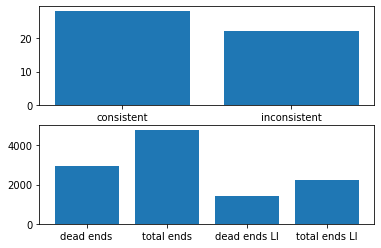

In [36]:
try_heuristic(
    runs=50,
    num_vars=9,
    constr_prob=0.3,
    max_intervals=5,
)